In [1]:
# Import third-party packages.
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, average_precision_score, classification_report, f1_score, precision_recall_curve, precision_recall_fscore_support, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
import warnings
from xgboost import XGBClassifier

%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)
warnings.filterwarnings('ignore')

In [255]:
# Read in preprocessed data on trees.
df = pd.read_csv('./data/data_preprocessed/features.csv')

poor = df.loc[df.health_Poor == 1].copy()
fair = df.loc[df.health_Fair == 1].copy()
fair_2 = fair.copy()
poor_2 = poor.copy()
poor_3 = poor.copy()

good = df.loc[df.health_Good == 1].copy()
df = pd.concat([df, poor, fair], ignore_index=True)

In [256]:
x = df.loc[:, 'steward_Alive':'n_neighbors_two or more neighbors']
y = df.loc[:, 'health_Dead|Stump':]

# Convert to .values later!
x_train, x_test, y_train, y_test = train_test_split(x,
                                                    y,
                                                    test_size=0.5,
                                                    random_state=None,
                                                    stratify=y)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13709d3d0>,
      dtype=object)

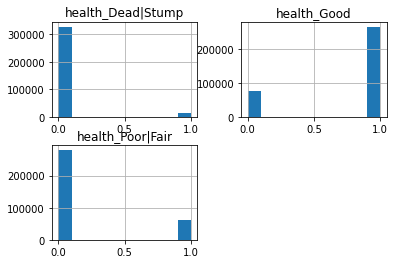

In [257]:
y_train.hist()

target_first_class = len(y_train.loc[y_train['health_Dead|Stump'] == 0]) / len(y_train)
target_second_class = len(y_train.loc[y_train['health_Fair'] == 0]) / len(y_train)
target_third_class = len(y_train.loc[y_train['health_Good'] == 0]) / len(y_train)
target_fourth_class = len(y_train.loc[y_train['health_Poor'] == 0]) / len(y_train)


class_weight_orig = [{0:target_first_class, 1:1-target_first_class},
                     {0:target_second_class, 1:1-target_second_class},
                     {0:target_third_class, 1:1-target_third_class},
                     {0:target_fourth_class, 1:1-target_fourth_class}]

class_weight_manip = [{0:target_first_class, 1:1-target_first_class},
                      {0:1-target_second_class-0.1, 1:target_second_class+0.1},
                      {0:target_third_class, 1:1-target_third_class},
                      {0:1-target_fourth_class, 1:target_fourth_class}]

print(class_weight_orig)
print(class_weight_manip)

# Undersampling

In [8]:
rs = RandomUnderSampler(sampling_strategy='majority', random_state=None)

In [9]:
x_train_us_1, y_train_us_1 = rs.fit_sample(x_train, y_train['health_Dead|Stump'])
x_train_us_3, y_train_us_3 = rs.fit_sample(x_train, y_train['health_Poor|Fair'])

us_deadstump = pd.concat([x_train_us_1, y_train_us_1], axis=1)
us_deadstump = us_deadstump.loc[us_deadstump['health_Dead|Stump'] == 1]
us_poorfair = pd.concat([x_train_us_3, y_train_us_3], axis=1)
us_poorfair = us_poorfair.loc[us_poorfair['health_Poor|Fair'] == 1]

us_remaining = pd.concat([x_train, y_train['health_Good']], axis=1)
us_remaining = us_remaining.loc[us_remaining['health_Good'] == 1]

df_us = pd.concat([us_deadstump, us_poorfair, us_remaining], ignore_index=True)
df_us.fillna(0, inplace=True)

In [10]:
len(df_us)

341894

In [13]:
x = df_us.loc[:, 'steward_Alive':'n_neighbors_two or more neighbors']
y = df_us.loc[:, 'health_Dead|Stump':]

# Convert to .values later!
x_train_us, x_test_us, y_train_us, y_test_us = train_test_split(x,
                                                                y,
                                                                test_size=0.5,
                                                                random_state=None,
                                                                stratify=y)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:304: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  i

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1311f33d0>,
      dtype=object)

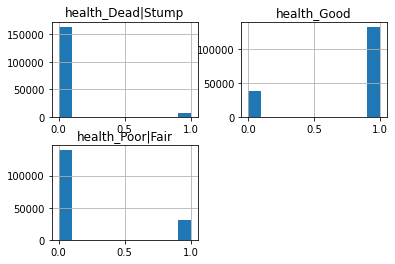

In [14]:
y_train_us.hist()

# SMOTE

In [50]:
smote_sampler = SMOTE(sampling_strategy='not majority', k_neighbors=100, random_state=None, n_jobs=-1)

In [54]:
x_train_smote, y_train_smote = smote_sampler.fit_sample(x.values, y.values)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:304: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  i

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1344f95e0>,
      dtype=object)

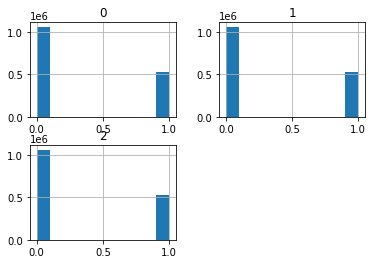

In [55]:
pd.DataFrame(y_train_smote).hist()

# Oversampling

In [258]:
ros = RandomOverSampler(sampling_strategy='minority', random_state=None)

In [259]:
x_train_ros, y_train_ros = ros.fit_resample(x.values, y.values)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x136397400>,
      dtype=object)

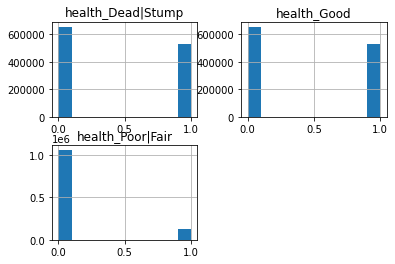

In [260]:
pd.DataFrame(y_train_ros, columns=df.columns[-3:]).hist()

In [136]:
smote_sampler = SMOTE(sampling_strategy='not majority', k_neighbors=10, random_state=None, n_jobs=-1)

In [137]:
x_train_smote, y_train_smote = smote_sampler.fit_sample(x_train_ros, y_train_ros)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:304: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  i

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1367e6550>,
      dtype=object)

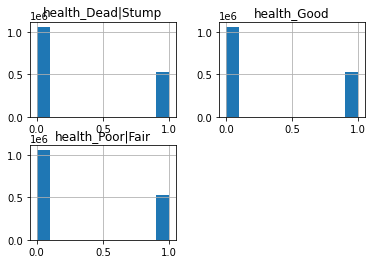

In [138]:
pd.DataFrame(y_train_smote, columns=df.columns[-3:]).hist()

# SMOTENN

In [4]:
smote_nn = SMOTEENN(sampling_strategy='minority', random_state=None, n_jobs=8)

In [5]:
x_train_smote_nn, y_train_smote_nn = smote_nn.fit_sample(x.values, y.values)

KeyboardInterrupt: 

In [ ]:
pd.DataFrame(y_train_smote_nn).hist()

# Mixture

In [ ]:
x_train_mix = pd.concat([x_train,
                         x_train_new_os.loc[y_train_new_os.loc[y_train_new_os['health_Poor'] == 1].index],
                         x_train_new_os.loc[y_train_new_os.loc[y_train_new_os['health_Fair'] == 1].index]], ignore_index=True)

In [ ]:
y_train_mix = pd.concat([y_train,
                         y_train_new_os.loc[y_train_new_os['health_Poor'] == 1],
                         y_train_new_os.loc[y_train_new_os['health_Fair'] == 1]], ignore_index=True)

In [ ]:
y_train_mix.hist()

In [ ]:
rdf_clf = RandomForestClassifier(n_jobs=-1)
rdf_clf.fit(x_train_mix, y_train_mix)
y_pred = rdf_clf.predict(x_test)
print(accuracy_score(y_test, y_pred))

In [ ]:
print(classification_report(y_test, y_pred, target_names=y.columns))

# Gridsearch

In [ ]:
parameter_grid = dict(n_estimators=[1000],
                      criterion=['entropy'],
                      max_features=[len(x.columns)])
gcv_rdf_clf = GridSearchCV(estimator=rdf_clf, param_grid=parameter_grid, cv=2, verbose=10, n_jobs=-1)

In [ ]:
accuracy_scores = cross_val_score(gcv_rdf_clf, x_train, y_train)
accuracy_scores

# Algorithms

In [261]:
xgb_clfs = {}

for each in y.columns:
    ind = list(y.columns).index(each)

    xgb_clfs[each] = {
                'trained_classifier': XGBClassifier(learning_rate=0.1,
                                                    gamma=1,
                                                    n_estimators=1,
                                                    max_depth=8,
                                                    subsample=0.8,
                                                    random_state=34,
                                                    nthread=-1) \
                                     .fit(x_train_ros,
                                          y_train_ros[:, ind])
                }
    xgb_clfs[each]['predictions'] = xgb_clfs[each]['trained_classifier'].predict(x_test.values)
    xgb_clfs[each]['accuracy'] = accuracy_score(y_test.values[:, ind],
                                                xgb_clfs[each]['predictions'])
    
    print(each, ': ', xgb_clfs[each]['accuracy'])
    print(classification_report(y_test.values[:, ind], xgb_clfs[each]['predictions']))
    print(average_precision_score(y_test.values[:, ind], xgb_clfs[each]['predictions'], average='micro'))

health_Dead|Stump :  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    326086
           1       1.00      1.00      1.00     15808

    accuracy                           1.00    341894
   macro avg       1.00      1.00      1.00    341894
weighted avg       1.00      1.00      1.00    341894

1.0
health_Good :  0.8223542969458371
              precision    recall  f1-score   support

           0       0.93      0.23      0.37     77469
           1       0.82      0.99      0.90    264425

    accuracy                           0.82    341894
   macro avg       0.87      0.61      0.64    341894
weighted avg       0.84      0.82      0.78    341894

0.8156900530345291
health_Poor|Fair :  0.8223308978806296
              precision    recall  f1-score   support

           0       0.82      1.00      0.90    280233
           1       0.63      0.04      0.07     61661

    accuracy                           0.82    341894
   macr

In [164]:
tes = np.array([[1,0,0,0,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0]])

In [252]:
tes = pd.Series([1,0,0,0,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0])

In [253]:
def classify_tree(tree, classifiers, targets):
    # tree = np.array([[1,0,0,0,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0]])
    # classifiers = xgb_clfs
    # targets = y

    results = {
        each: classifiers[each]['trained_classifier'].predict(tree)
        for each in targets.columns
        }

    if (int(sum(results.values())) == 0) | (int(sum(results.values())) > 1):
        print("This tree cannot be classified.")
    else:
        if int(results['health_Dead|Stump']) == 1:
            message = "This is a dead or stump tree."
        elif int(results['health_Good']) == 1:
            message = "This is a healthy tree."
        else:
            message = "This is a tree in a poor or fair health condition."
            
    return results, message

a, c = classify_tree(tes, xgb_clfs, y)

In [262]:
with open('xgb_clfs.pickle', 'wb') as handle:
    pickle.dump(xgb_clfs, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
n_classes = y.shape[1]

#random_state = np.random.RandomState(0)
#n_samples, n_features = X.shape
#X = np.c_[X, random_state.randn(n_samples, 500 * n_features)]

#____________________________________________________________________
# training test splitting
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=19)


#one_vs_rest = OneVsRestClassifier(SVC(kernel='rbf', C=10, gamma=100, probability=True, random_state=12))
y_score = one_vs_rest.fit(X_train, y_train).decision_function(X_test)
#y_true, y_pred = y_test, one_vs_rest.predict(X_test)

precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                        y_score[:, i])
    average_precision[i] = average_precision_score(y_test[:, i], y_score[:, i])

#____________________________________________________________________
# Plot Precision-Recall curve for each class
fig = plt.figure(1, figsize=(9, 7))
plt.clf()
for i, color in zip(range(n_classes), colors):
    plt.plot(recall[i], precision[i], color=color, lw=2,)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('recall')
plt.ylabel('precision')
plt.legend(loc="lower right")
plt.show()

In [ ]:
ada_clf = AdaBoostClassifier()

for each in range(y_train.shape[1]):
    ada_clf.fit(x_train, y_train[:, each])
    ada_y_pred = ada_clf.predict(x_test)
    print(y.columns[each], accuracy_score(y_test[:, each], ada_y_pred))

In [ ]:
for each in range(y_train.shape[1]):
    print(classification_report(y_test[:, each], ada_y_pred))
    print(roc_auc_score(y_test[:, each], ada_y_pred))
    print(average_precision_score(y_test[:, each], ada_y_pred, average='micro'))

In [65]:
target_first_class = len(y_train_smote[:, 0][y_train_smote[:, 0] == 0]) / len(y_train_smote)
target_second_class = len(y_train_smote[:, 1][y_train_smote[:, 1] == 0]) / len(y_train_smote)
target_third_class = len(y_train_smote[:, 2][y_train_smote[:, 2] == 0]) / len(y_train_smote)

class_weight_orig = [{0:target_first_class, 1:1-target_first_class},
                     {0:target_second_class, 1:1-target_second_class},
                     {0:target_third_class, 1:1-target_third_class}]

class_weight_manip = [{0:0.2, 1:0.8},
                      {0:0.2, 1:0.8},
                      {0:0.2, 1:0.8}]

print(class_weight_orig)
print(class_weight_manip)

[{0: 0.6666666666666666, 1: 0.33333333333333337}, {0: 0.6666666666666666, 1: 0.33333333333333337}, {0: 0.6666666666666666, 1: 0.33333333333333337}]
[{0: 0.2, 1: 0.8}, {0: 0.2, 1: 0.8}, {0: 0.2, 1: 0.8}]


In [75]:
rdf_clf = RandomForestClassifier(class_weight=class_weight_manip, n_jobs=-1)

rdf_clf.fit(x_train_ros, y_train_ros)
y_pred = rdf_clf.predict(x_test)
print(accuracy_score(y_test, y_pred))

0.8228047289510784


In [76]:
print(classification_report(y_test, y_pred, target_names=df.columns[-3:]))
print(roc_auc_score(y_test, y_pred))
average_precision_score(y_test, y_pred, average='micro')

                   precision    recall  f1-score   support

health_Dead|Stump       1.00      1.00      1.00     15808
      health_Good       0.82      1.00      0.90    264425
 health_Poor|Fair       0.65      0.04      0.07     61661

        micro avg       0.82      0.82      0.82    341894
        macro avg       0.82      0.68      0.66    341894
     weighted avg       0.79      0.82      0.75    341894
      samples avg       0.82      0.82      0.82    341894

0.7104426065038805


0.7360727123338981

In [ ]:
precision = dict()
recall = dict()
average_precision = dict()
for i in range(3):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                        ada_y_pred)
    average_precision[i] = average_precision_score(y_test[:, i], ada_y_pred)

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test.ravel(),
    ada_y_pred.ravel())
average_precision["micro"] = average_precision_score(y_test, ada_y_pred,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, label="ROC Curve SVC")
plt.plot(fpr_rf, tpr_rf, label="ROC Curve RF")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10,
label="threshold zero SVC", fillstyle="none", c='k', mew=2)
close_default_rf = np.argmin(np.abs(thresholds_rf - 0.5))
plt.plot(fpr_rf[close_default_rf], tpr[close_default_rf], '^', markersize=10,
label="threshold 0.5 RF", fillstyle="none", c='k', mew=2)
plt.legend(loc=4)

# Save current status

In [ ]:
pickle.dump(rdf_clf, open('rdf.pkl', 'wb'))